(dask-read-write)=
# 读写数据

Dask DataFrame 支持 pandas 中几乎所有的数据读写操作，包括从本地、NFS、HDFS 或 S3 上读写文本文件、Parquet、HDF、JSON 等格式的文件。 {numref}`dask-read-write-operations` 是几个常见的读写操作。

```{table} 几个 Dask DataFrame 读写操作示例
:name: dask-read-write-operations
|   	| CSV          	| Parquet          	| HDF          	|
|---	|--------------	|------------------	|--------------	|
| 读  	| [`read_csv()`](https://docs.dask.org/en/stable/generated/dask.dataframe.read_csv.html) 	| [`read_parquet()`](https://docs.dask.org/en/stable/generated/dask.dataframe.read_parquet.html) 	| [`read_hdf()`](https://docs.dask.org/en/stable/generated/dask.dataframe.read_hdf.html) 	|
| 写  	| [`to_csv()`](https://docs.dask.org/en/stable/generated/dask.dataframe.to_csv.html)   	| [`to_parquet()`](https://docs.dask.org/en/stable/generated/dask.dataframe.to_parquet.html)   	| [`to_hdf()`](https://docs.dask.org/en/stable/generated/dask.dataframe.to_hdf.html)   	|
```

## 文件系统

:::{tip}
当我们在使用 Dask 集群读写数据时，数据源应该存储在 NFS、HDFS、S3 这种共享文件系统，这样所有 Dask Worker 都能访问该数据。
:::

业内经常使用文件系统前缀（Scheme）来标识不同的文件系统，并调用不同的库来读写文件系统。{numref}`uri-schemes` 是几个 Scheme 例子。一个数据集地址，应该是一个统一资源标识（Uniform Resource Identifier，URI），URI 包括 Scheme 和具体的地址，URI 模板为：`scheme://path/to/data`。比如：`file:///tmp/tripdata.parquet` 或 `s3://tmp/tripdata.parquet`。

```{table} URI Scheme
:name: uri-schemes
|        	|   本地   	|   S3  	|  HDFS 	|
|:------:	|:--------:	|:-----:	|:--------:	|
| Scheme 	| file:// 	| s3:// 	| hdfs:// 	|
```

如果数据集地址没有加任何 Scheme，会假设是本地可访问的文件系统，即该计算节点可以直接读写和访问的文件系统。比如，网络文件系统（Network File System，NFS）是分布式文件系统，假如被挂载到多个计算节点的 `/mnt/nfs` 目录，使用 Dask 读写该目录时，可直接使用 `/mnt/nfs` 这个目录。

本书后续介绍的 Ray Data 等也依照同样 URI 和 Scheme 标准。

HDFS 和 S3 这样共享文件系统，在企业或组织中被多人共享，因此经常有用户验证的环节，以做好用户之间的数据隔离，避免用户互相修改或删除数据。不同的文件系统有自己的用户验证的方式，比如，S3 用户需要提供令牌（Token），Token 可以通过 `read_*()` 和 `to_*()` (包括 `read_csv()`、`read_parquet`、`to_parquet()` 等方法) 的 `storage_options` 参数传递进来。如果你对用户验证不熟悉，应咨询组织中负责运维管理的同事。

## 数据切分与并行读取

我们以读取逗号分隔的数值（Comma-Separated Values，CSV）文件为例，来展示 Dask DataFrame 与 pandas 的区别。

In [14]:
import os
import glob
import urllib
import shutil
from zipfile import ZipFile

import dask.dataframe as dd
import pandas as pd
from dask.distributed import LocalCluster, Client

cluster = LocalCluster()
client = Client(cluster)

folder_path = os.path.join(os.getcwd(), "../data/")
download_url = "https://dp.godaai.org/nyc-flights.zip"
zip_file_path = os.path.join(folder_path, "nyc-flights.zip")
if not os.path.exists(os.path.join(folder_path, "nyc-flights")):
    with urllib.request.urlopen(download_url) as response, open(zip_file_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
        zf = ZipFile(zip_file_path, 'r')
        zf.extractall(folder_path)
        zf.close()

file_path = os.path.join(folder_path, "nyc-flights", "*.csv")
print(file_path)

/Users/luweizheng/Projects/godaai/distributed-python/ch-dask-dataframe/../data/nyc-flights/*.csv


pandas 和 Dask DataFrame 都提供了 `read_csv()` 方法，用来读取 CSV 文件。Dask 的 [`read_csv()`](https://docs.dask.org/en/stable/generated/dask.dataframe.read_csv.html) 参数与 pandas 几乎一致，可以参考 pandas 的 [`read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)。比如在这个例子中，原始数据有很多列，其中前三列分别为，年：`Year`，月：`Month`，日：`DayofMonth`，`read_csv()` 方法的 `parse_dates` 参数将这三列解析为时间 `datetime64` 类型，并生成一个新的列 `Date`。

In [15]:
ddf = dd.read_csv(file_path, parse_dates={'Date': [0, 1, 2]})

这里的 `file_path` 是 `*.csv` 的形式，匹配所有以 `csv` 结尾的文件；而 pandas 的 `read_csv()` 只能读取单个文件，并不支持 `*.csv` 这样的通配符。如果想用 pandas 读文件夹下面的所有以 `csv` 结尾的文件，应该：

In [16]:
file_list = glob.glob(file_path)
data = []

for p in file_list:
    df = pd.read_csv(p, parse_dates={'Date': [0, 1, 2]})
    data.append(df)

pdf = pd.concat(data)

查看这份数据的前 3 行：

In [17]:
ddf.head(3)

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1991-01-08,2,1215.0,1215,1340.0,1336,US,121,NaN,85.0,...,NaN,4.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1991-01-09,3,1215.0,1215,1353.0,1336,US,121,NaN,98.0,...,NaN,17.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1991-01-10,4,1216.0,1215,1332.0,1336,US,121,NaN,76.0,...,NaN,-4.0,1.0,EWR,PIT,319.0,NaN,NaN,0,0


In [18]:
pdf.head(3)

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1991-01-08,2,1215.0,1215,1340.0,1336,US,121,NaN,85.0,...,NaN,4.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1991-01-09,3,1215.0,1215,1353.0,1336,US,121,NaN,98.0,...,NaN,17.0,0.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1991-01-10,4,1216.0,1215,1332.0,1336,US,121,NaN,76.0,...,NaN,-4.0,1.0,EWR,PIT,319.0,NaN,NaN,0,0


这里体现出 Dask DataFrame 与 pandas 的区别：Dask DataFrame 接受 `*.csv` 这样的通配符，可以批量读取文件夹下所有的以 `csv` 结尾的文件。Dask DataFrame 在实现时，先对 `*.csv` 目录进行了遍历，了解到目录下一共有多少个 CSV 文件，并在构建 Task Graph 时，根据文件数量，并行地启动多个 pandas 进程。

`ddf.visualize()` 将 Task Graph 进行了可视化，可以看到：目录下有 m 个 CSV 文件，在 Task Graph 中生成 m 个 `read_csv()` 子图，执行时并行地启动 m 个 pandas 的 `read_csv()`；或者说，每个 CSV 文件对应一个 Partition。根据文件数量构建 Task Graph 中的并行粒度是一种最简单的图生成方式。

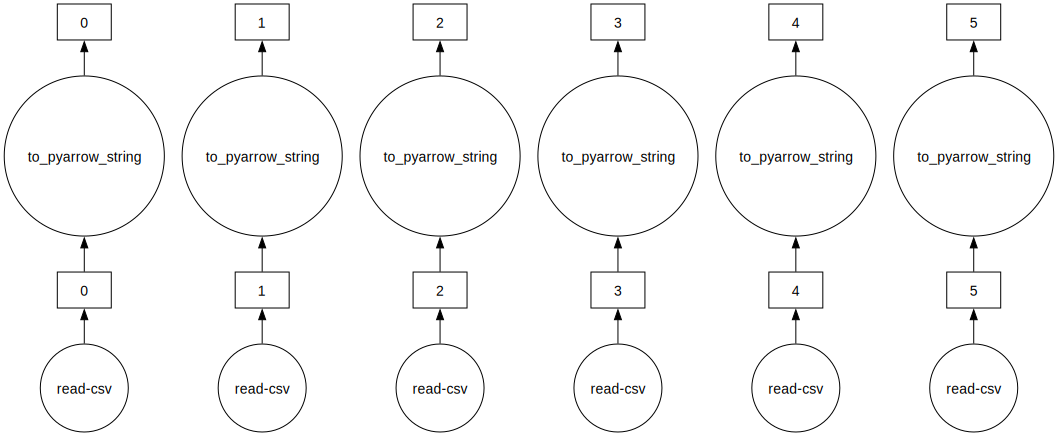

In [19]:
ddf.visualize(filename="../img/ch-dask-dataframe/nyc-flights-graph", format="svg")

这个例子中，Dask 根据文件数量来确定 Partition 的数量。{numref}`dask-task-graph` 提到，数据切分得过细或者过粗都不是最好的。对于所有可能的场景来说，单纯根据文件数量来确定切分为多少个 Partition 的方式并不一定是最优的：因为如果很多小文件，切分粒度会过细；或者如果是单个大文件，切分粒度过粗，可能导致 OOM。这两种极端情况下生成的 Task Graph 和并行粒度都不是最优的。所以，Dask DataFrame 的 `read_csv()` 提供了自定义每个 Partition 大小的参数 `blocksize`，单个 Partition 的大小不会超过 `blocksize`。如果用户没有显式设置 `blocksize`，Dask DataFrame 会根据探测到的计算资源情况来确定 `blocksize`，最大不超过 64MB。

## 数据表模式推理

在读取这些数据时，Dask DataFrame 对数据的类型和表模式进行了推测，并将字段名、字段对应的数据类型等表模式记录下来。Dask DataFrame 的 `read_csv()` 有 `sample` 的参数，表示只读取前面 `sample` 字节大小的数据，并根据这些数据来推测数据类型。这会带来下面的问题：

获取 `ddf` 的最后 3 行：

In [20]:
import traceback
try:
    ddf.tail(3)
except Exception:
    traceback.print_exc()

2024-02-09 17:43:50,091 - distributed.worker - WARNING - Compute Failed
Key:       ('to_pyarrow_string-be40c5ef4347788c673803e766c9f5ac', 5)
Function:  execute_task
args:      ((subgraph_callable-9daf7b14-cf6d-4b93-b345-9197c71b1866, [(<function read_block_from_file at 0x119cfd3a0>, <OpenFile '/Users/luweizheng/Projects/godaai/distributed-python/ch-dask-dataframe/../data/nyc-flights/1996.csv'>, 0, 24979433, b'\n'), None, True, True]))
kwargs:    {}
Exception: 'ValueError(\'Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.\\n\\n+----------------+---------+----------+\\n| Column         | Found   | Expected |\\n+----------------+---------+----------+\\n| CRSElapsedTime | float64 | int64    |\\n| TailNum        | object  | float64  |\\n+----------------+---------+----------+\\n\\nThe following columns also raised exceptions on conversion:\\n\\n- TailNum\\n  ValueError("could not convert string to float: \\\'N14346\\\'")\\n\\nUsually this is due to dask\\\'s dtype inference failing

`traceback` 将 `ddf.tail(3)` 抛出的异常捕获。为什么抛出了异常？因为 Dask DataFrame 并没有把所有数据都读取出来，而只是读取了 `sample` 大小的数据。恰好这些数据中，`CRSElapsedTime` 列是空的，Dask DataFrame 猜测该字段为 `float64` 类型，但后面的行有数据了，是 `int64` 类型。或者说，Dask DataFrame 猜测的字段数据类型和最后实际遇到的数据类型不一致。

针对这种情况，应该在最开始读取数据的时候就明确数据类型，而不是依赖 Dask 的表模式推测：

In [21]:
ddf = dd.read_csv(file_path,
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': object,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})
ddf.tail(3)

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
259511,1996-12-29,7,2008.0,1640,2236.0,1852,UA,1659,N424UA,268.0,...,225.0,224.0,208.0,LGA,DEN,1619.0,8.0,35.0,False,0
259512,1996-12-30,1,1644.0,1640,1855.0,1852,UA,1659,N401UA,251.0,...,235.0,3.0,4.0,LGA,DEN,1619.0,5.0,11.0,False,0
259513,1996-12-31,2,1659.0,1640,1902.0,1852,UA,1659,N414UA,243.0,...,216.0,10.0,19.0,LGA,DEN,1619.0,5.0,22.0,False,0


依然使用刚才的例子，我们加上 `blocksize` 参数，分别设置为 `50_000` 和 `5_000_000`，比较一下不同 Partition 下计算速度，也可以观察 Dask 仪表盘上提供的各类信息。`blocksize` 为 `50_000` 时，Task Graph 切分粒度更细，计算图更大，复杂的计算图带来额外开销使得总体耗时更长。

In [22]:
%%time
ddf = dd.read_csv(file_path, 
                parse_dates={"Date": [0, 1, 2]},
                dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
                blocksize=50_000)

origin_cnt = ddf[~ddf.Cancelled].groupby("Origin").Origin.count().compute()
print(origin_cnt)

Origin
EWR    669254
JFK    255485
LGA    591305
Name: Origin, dtype: int64
CPU times: user 1.77 s, sys: 701 ms, total: 2.47 s
Wall time: 5.62 s


In [23]:
%%time
ddf = dd.read_csv(file_path, 
                parse_dates={"Date": [0, 1, 2]},
                dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
                blocksize=5_000_000)

origin_cnt = ddf[~ddf.Cancelled].groupby("Origin").Origin.count().compute()
print(origin_cnt)

Origin
EWR    669254
JFK    255485
LGA    591305
Name: Origin, dtype: int64
CPU times: user 48.6 ms, sys: 16.1 ms, total: 64.6 ms
Wall time: 509 ms


## Parquet

在大数据工程领域，[Apache Parquet](https://parquet.apache.org/) 是一种被广泛应用的文件格式。相比 CSV 等纯文本类型文件，Parquet 有以下优势：

* 列式存储
* 内嵌表模式
* 数据压缩

具体而言，列式存储按照列进行存储，而不是 CSV 那样按行存储。数据分析时，我们可能只关心特定的列，而不是所有的列，因此在读取数据时，Parquet 允许很方便地过滤掉不需要的列，而不必读取整个行。因为减少了读取的数据量，Parquet 可以显著提高性能，也被广泛应用在 Apache Spark、Apache Hive 和 Apache Flink 等大数据生态。Parquet 自带了表模式，每个 Parquet 文件里嵌入了每个列的列名、数据类型等元数据，也就避免了 Dask DataFrame 进行表模式推测时推测不准确的问题。Parquet 中的数据是经过压缩的，相比 CSV，Parquet 更节省持久化存储的空间。

比如，应该尽量读取所需要的列，而不是所有的列。

```python
dd.read_parquet(
    "s3://path/to/parquet/",
    columns=["a", "b", "c"]
)
```

此外，Parquet 提供了行分组（Row Group）的概念，如 {numref}`parquet-row-group` 所示，Parquet 文件中的数据是分组的，Row Group 定义了一个组内有多少行，这个例子中，一共 3 个 Row Group，每个 Row Group 有 2 行数据。每个 Row Group 存储了列的最大值和最小值等元数据，对这些列进行某些查询时，通过元数据的信息就可以确定是否读取这个 Row Group。比如，某时间列是一个时间序列，查询 “每天 9:00 至 12:00 的销量”，Row Group 中的元数据记录了时间列的最大值和最小值，通过元数据就可以判断是否有必要把这个 Row Group 读取出来，避免了读取不必要的开销。

```{figure} ../img/ch-dask-dataframe/parquet-row-group.svg
---
width: 600px
name: parquet-row-group
---
Parquet 列式存储与 Row Group
```

由于 Row Group 的引入，一个 Parquet 文件内可能有多个组，也就是说 Parquet 文件帮我们做了分组；不过很多 Parquet 文件的 Row Group 是 1。

通常，数据集的文件被拆分为多个 Parquet，并且按照一定的方式来组织。比如，按照时间来切分：

```
/path/folder/
.../year/month/day.parquet
```

Dask DataFrame 在读取 Parquet 数据集时，除了根据文件数量外，又多了一个可能的依据：Row Group。如果有 m 个文件，那 Partition 可能的选项有：

* 每个 Parquet 文件对应 Dask 的一个 Partition，共有 m 个 Partition
* 每个 Row Group 对应 Dask 的一个 Partition，假如一个 Parquet 文件有 n 个 Row Group，共有 m * n 个 Partition

但无论哪种方式，应该尽量保证每个 Partition 所占用的内存空间不超过 Worker 的物理内存空间。Dask DataFrame 的
`read_parquet()` 通过 `split_row_groups` 参数给用户更多选项。默认为 `split_row_groups="infer"`：Dask DataFrame 根据 Parquet 文件中的元数据来推测，是每个文件对应一个 Partition，还是每个 Row Group 对应一个 Partition；如果设置为 `split_row_groups=True` 则强制每个 Row Group 对应一个 Partition；如果设置为 `False`，则每个文件对应一个 Partition。

In [24]:
client.shutdown()